# Homework 4 - Revised with corrections
## Wes Roberts

I will note where I've made corrections to the code. The idea is that when the system is evolved 100 or 50 times, at each step the "instantaneous" temperature should be taken. The temperature is a thermodynamic average, so the average of these instantaneous values is what should be used for the rescaling.

Import required libraries

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot
import matplotlib.animation as animation
from IPython.display import HTML
import math
import itertools as itool

Define two lists of values that correspond to boundary conditions and initial configuration

In [2]:
class BoundaryCondition:
    RBC, PBC = range(2)
    
class StartConf:
    Triangular, Rectangular, Random, Confined = range(4)

In [3]:
StartConf.Confined

3

Define the particle object

In [4]:
class particle2(object):

    def __init__(self, mass=1., x=0., y=0., vx=0., vy=0.):
        self.mass = mass
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        self.fx = 0.
        self.fy = 0.
       
    def euler(self, fx, fy, dt):
        self.vx = self.vx + self.fx/self.mass*dt
        self.vy = self.vy + self.fy/self.mass*dt
        self.x = self.x + self.vx*dt
        self.y = self.y + self.vy*dt
        
    def accel(self, dt):                                # Pushes velocity ahead one timestep
        self.vx = self.vx + self.fx/self.mass*dt
        self.vy = self.vy + self.fy/self.mass*dt
        
    def move(self, dt, dt2half):                                 # pushes position ahead one timestep
        self.x = self.x + self.vx*dt + self.fx/self.mass*dt2half
        self.y = self.y + self.vy*dt + self.fy/self.mass*dt2half

The move function pushes the particle ahead one timestep, under influence of the instantaneously defined force. Note that the presence of dt2half rather than $(0.5)*dt**2$ reduces computational burden.

Now we define the molecular dynamics system as an object. This will be populated with our 12 particles for the project. 

## Following code is corrected.

In [5]:
class MDsystem(object):

    def __init__(self, lx, ly, N, dt, bc):   # creates the object 
        self.N = N                           # System contains N specified particles
        self.lx = ly
        self.ly = lx                         # defined in a 2D box lx by ly
        self.dt = dt                         # a time step is defined
        self.dt2 = dt*dt
        self.dthalf = dt * 0.5
        self.dt2half = self.dt2 * 0.5        # rather than computing 0.5 * dt**2 in the code
        self.bc = bc                         # boundary conditions are specified when object is created
        self.particles = [particle2()]
        for i in range(1,N):
            self.particles.append(particle2()) # we create a list of N particles

    def init(self, config, vmax):               # initializes system with some defined configuration and velocities
        np.random.seed(1272121) # arbitrary seed
        nrows = int(math.sqrt(self.N)*float(self.ly)/float(self.lx))
        ncols = int(math.sqrt(self.N)*float(self.lx)/float(self.ly))
        ax = float(lx) / float(ncols)
        ay = float(ly) / float(nrows)           
        i = 0

        if config == StartConf.Triangular:     # define the possible config inputs
            #Challenge
            nrows = int(math.sqrt(self.N))
            ncols = int(nrows)
            ax = float(lx)/float(ncols)
            ay = float(ly)/float(nrows)
            for row, col in itool.product(range(nrows),range(ncols)):
                self.particles[i].x = col*ax+ax/2.
                if row%2 == 1:
                    self.particles[i].x += ax/2.
                self.particles[i].y = row*ay+ay/2.
                i+=1
        elif config == StartConf.Rectangular:
            for row, col in itool.product(range(nrows),range(ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = col*ax+ax/2.
                self.particles[i].y = row*ay+ay/2.
                i+=1

            for row, col in itool.product(range(1,nrows),range(1,ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = col*ax+ax/2.+ax/4.
                self.particles[i].y = row*ay+ay/2.+ay/4.
                i+=1
                
        elif config == StartConf.Confined:
            ax /= 2.
            for row, col in itool.product(range(nrows),range(ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = col*ax+ax/2.
                self.particles[i].y = row*ay+ay/2.
                i+=1

            for row, col in itool.product(range(nrows),range(ncols)):
                if i >= self.N: 
                    break
                self.particles[i].x = col*ax+ax/2.+ax/4.
                self.particles[i].y = row*ay+ay/2.+ay/4.
                i+=1
                
        elif config == StartConf.Random:
            for i in range(self.N):
                overlap = True;
                while overlap:
                    overlap = False;
                    self.particles[i].x = np.random.random()*self.lx
                    self.particles[i].y = np.random.random()*self.ly
                    for j in range(i):
                        r12 = self.distance(self.particle[i], self.particle.p[j])
                        if r12 < 1.: 
                            overlap = True;
                            break
                                
        # Velocities
        for p in self.particles:                         # Assign each particle a random initial velocity
            p.vx = vmax*(2. * np.random.random() - 1);
            p.vy = vmax*(2. * np.random.random() - 1);

        # We set total momentum to zero
        vxcm = 0.
        vycm = 0. # Velocity of the center of mass
        for p in self.particles:
            vxcm += p.vx;        # add up all the particle velocities in the system
            vycm += p.vy;
        
        vxcm /= self.N
        vycm /= self.N           # divide by N. Now vcm is average velocity per particle, ie CoM
        for p in self.particles:
            p.vx -= vxcm;
            p.vy -= vycm;        # with this defined, subtract the CoM velocity from each particle velocity
                                # The system now has no overall velocity. The system itself will not translate. 
        self.forces()          
        
    def evolve(self):              # evolve() pushes the positions and velocities ahead one time step
        for p in self.particles:
            p.move(self.dt, self.dt2half)
            p.accel(self.dthalf)
            self.boundary(p)        # operate with the boundary function
                                    # for example if RBC, particles that went outside "bounce" back in
        self.forces()

        for p in self.particles:
            p.accel(self.dthalf)

        
    def distance(self, p, other):    # this one just returns the magnitude separation between a pair (see below)      
        (r12, dx, dy) = self.distance2(p, other)
        return math.sqrt(r12)

    def distance2(self, p, other):   # for a given pair, find the vector separation between them
        dx = other.x - p.x;
        dy = other.y - p.y;


        # nearest image convention
        if self.bc == BoundaryCondition.PBC:   # In PBC we need extra code to always take the shortest distance
            if abs(dx) > self.lx/2:
                dx -= dx*lx/abs(dx)
                
            if abs(dy) > self.ly/2:
                dy -= dy*ly/abs(dy)
        
        r12 = dx * dx + dy * dy       # also calculates the squared magnitude distance r12
        return (r12, dx, dy)          # returns all three values

    def force(self, p, other):  #Lennard-Jones
        (r12,dx,dy) = self.distance2(p, other)   # grabs the distance and squared separation for the pair
        r2 = 1./r12
        r6 = r2 * r2 * r2                     # calculating in this way reduces computation time
        f = 24.*r2*r6*(2.*r6-1.)
        fx = f*(-dx)
        fy = f*(-dy)
        return (fx, fy);                    # returns force in x and y on p
      
    def forces(self):
        # Compute the interaction forces between particles
        for p in self.particles:
            p.fx = 0.
            p.fy = 0.
    
        for i in range(self.N):
            p = self.particles[i]
            for j in range(i+1,self.N):   # only taking j > i to avoid double-counting
                other = self.particles[j]
                (fx, fy) = self.force(p, other)
                p.fx += fx
                p.fy += fy
                other.fx -= fx     # Newton's 3rd
                other.fy -= fy

    def boundary(self, p):
        if self.bc == BoundaryCondition.RBC:     # the boundary() function enforces selected boundary conditions
            
            if p.x < 0:  
                p.x = -p.x
                p.vx = -p.vx       # defines a "bounce" if a particle leaves the box
            if p.y < 0:
                p.y = -p.y
                p.vy = -p.vy
            if p.x > self.lx:
                p.x = 2*self.lx - p.x
                p.vx = -p.vx
            if p.y > self.ly:
                p.y = 2*self.ly - p.y
                p.vy = -p.vy

        elif self.bc == BoundaryCondition.PBC:

            if p.x < 0: 
                p.x += lx      # If it goes outside the box, appropriately shift it back inside
            elif p.x > lx:  
                p.x -= lx
            if p.y < 0:  
                p.y += ly
            elif p.y > ly:  
                p.y -= ly
                
# this is where the assignment actually begins
            
    def kinetic_energy(self): # add up all the v**2
        ke = 0.
        for p in self.particles:
            vx2 = p.vx**2
            vy2 = p.vy**2
            vx2half = (0.5)*vx2
            vy2half = (0.5)*vy2
            ke += vx2half + vy2half
        return ke
    
    def inst_temp(self):     # CORRECTION: renamed this. It's not actually a thermodynamic average.
        temp = 0.
        for p in self.particles:
            vx2 = p.vx**2
            vy2 = p.vy**2
            v2 = vx2 + vy2
            temp += v2
        temp /= self.N
        temp /= 3.          
        return temp
    
    # deleted the previous rescale function. Added a new one below that works better with the adjusted code. 
    
    def pot_energy(self): # add up all the particle-particle Lennard_Jones interactions
        pe = 0.
       
        for i in range(self.N):
            p = self.particles[i]
            for j in range(i+1,self.N):   # only taking j > i to avoid double-counting
                other = self.particles[j]
                v = self.potential(p, other)
                pe += v
               
        return pe
    
    def potential(self, p, other):  #Lennard-Jones
        (r12,dx,dy) = self.distance2(p, other)   # grabs the distance and squared separation for the pair
        r2 = 1./r12
        r6 = r2 * r2 * r2                     # calculating in this way reduces computation time
        v = 4.*r6*(r6-1.)
        return v;                    # returns potential energy between p and other
      
        
    def total_energy(self):
        return self.kinetic_energy()+self.pot_energy()
    
    
    def evolve100(self):  # Write a function that evolves the system forward 100 time steps
        for i in range(100):
            self.evolve()
    
    def evolve50(self):
        for i in range(50):
            self.evolve()
            
    # CORRECTION: adding evolution function that also finds the true temperature over those 50 or 100 steps
    # it should output the thermodynamic temperature using inst_temp
    
    def Temp_evolve(self, steps):
        T_sum = 0.             # Initialize a running sum of the instantaneous temps to be divided by the total
        for i in range(steps):
            self.evolve()
            T_sum += self.inst_temp()
        T_sum = T_sum/steps
        return T_sum          # output is the actual temperature
    
    def auto_rescale(self, Tdes, steps):    # Adding a new rescale function that finds the temp over 100 steps, then rescales
        Temp = self.Temp_evolve(steps)    # Finds the temperature of the system (NOT INSTANTANEOUS)
        factor = Tdes/Temp
        rtfactor = math.sqrt(factor)
        for p in self.particles:     # given the temperature, rescales velocities
            p.vx *= rtfactor
            p.vy *= rtfactor
            
        return Temp                  # output is the temperature before the rescaling

## I'm deleting a lot of cells that were just me convincing myself that the previous code had worked. 

In [6]:
lx = 8
ly = 8
N = 12
dt = 0.0001
v0 = 1

Y = MDsystem(lx, ly, N, dt, BoundaryCondition.PBC)
Y.init(StartConf.Confined, v0)

#print(Y.Temp_evolve(100))

Obtain a plot showing convergence to the desired temperature. Begin with T = 1.

In [7]:
# Write a loop that does 10 iterations of 100 time steps.
# It needs to output the temperature at each step (10 of them).

time_array1 = np.zeros(10)
temp_array1 = np.zeros(10) 

for i in range(10):
    temp_array1[i] = Y.auto_rescale(1,100)  # Get the temperature. Desired T = 1, 100 steps. Velocities also rescaled. 
    time_array1[i] = dt*i*100
    

In [8]:
temp_array1

array([9.56042707, 2.61278081, 1.37643491, 1.13598593, 1.03948562,
       0.99966046, 0.9840216 , 0.97925699, 0.97935633, 0.98150313])

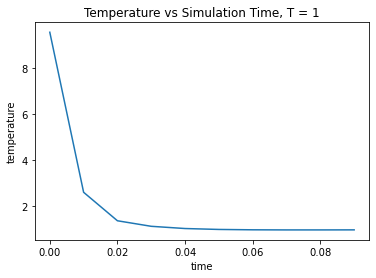

In [9]:
pyplot.plot(time_array1, temp_array1);
pyplot.title('Temperature vs Simulation Time, T = 1')
pyplot.xlabel('time')
pyplot.ylabel('temperature');

Notice that here the time step is very small. If I use dt = .02 per the instructions, convergence is very fast.

CORRECTION: This is looking like genuine convergence to the desired temperature, starting from a confined initial condition. I will move forward with this code to see what happens.

[1.63592917e+14 1.29437484e+00 1.00096577e+00 1.01349544e+00
 9.85997711e-01 1.01215607e+00 9.91055445e-01 9.98597398e-01
 1.02397366e+00 9.94164561e-01]


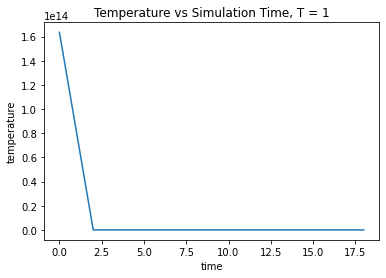

In [10]:
lx = 8
ly = 8
N = 12
dt = 0.02
v0 = 1

Y = MDsystem(lx, ly, N, dt, BoundaryCondition.PBC)
Y.init(StartConf.Confined, v0)


time_array1 = np.zeros(10)
temp_array1 = np.zeros(10)

for i in range(10):
    temp_array1[i] = Y.auto_rescale(1,100)   
    time_array1[i] = dt*i*100
    
print(temp_array1)
    
pyplot.plot(time_array1, temp_array1);
pyplot.title('Temperature vs Simulation Time, T = 1')
pyplot.xlabel('time')
pyplot.ylabel('temperature');

Now do the same for T = 2, 4

[1.63592917e+14 2.58874937e+00 2.00096487e+00 2.01349832e+00
 1.98590041e+00 2.01191306e+00 1.99154959e+00 1.99780559e+00
 2.02498677e+00 1.99427594e+00]


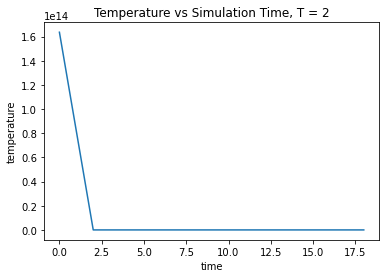

In [11]:
# for T = 2
lx = 8
ly = 8
N = 12
dt = 0.02
v0 = 1

Z = MDsystem(lx, ly, N, dt, BoundaryCondition.PBC)
Z.init(StartConf.Confined, v0)

time_array2 = np.zeros(10)
temp_array2 = np.zeros(10)

for i in range(10):
    temp_array2[i] = Z.auto_rescale(2,100)
    time_array2[i] = dt*i*100

print(temp_array2)   # Printing these so that convergence can be seen.
    
pyplot.plot(time_array2, temp_array2);
pyplot.title('Temperature vs Simulation Time, T = 2')
pyplot.xlabel('time')
pyplot.ylabel('temperature');

In [12]:
temp_array2

array([1.63592917e+14, 2.58874937e+00, 2.00096487e+00, 2.01349832e+00,
       1.98590041e+00, 2.01191306e+00, 1.99154959e+00, 1.99780559e+00,
       2.02498677e+00, 1.99427594e+00])

[1.63592917e+14 5.17749842e+00 4.00096361e+00 4.01350153e+00
 3.98585057e+00 4.01176540e+00 3.99185780e+00 3.99747491e+00
 4.02543225e+00 3.99462699e+00]


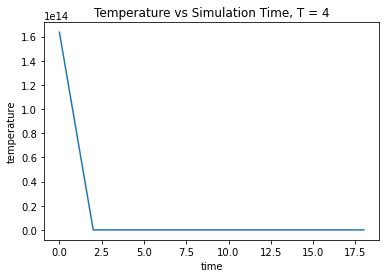

In [13]:
# and for T = 4

lx = 8
ly = 8
N = 12
dt = 0.02
v0 = 1

Z = MDsystem(lx, ly, N, dt, BoundaryCondition.PBC)
Z.init(StartConf.Confined, v0)

time_array3 = np.zeros(10)
temp_array3 = np.zeros(10)

for i in range(10):
    temp_array3[i] = Z.auto_rescale(4,100)
    time_array3[i] = dt*i*100

print(temp_array3)   # Printing these so that convergence can be seen.
    
pyplot.plot(time_array3, temp_array3);
pyplot.title('Temperature vs Simulation Time, T = 4')
pyplot.xlabel('time')
pyplot.ylabel('temperature');

In each case we do see convergence to the desired temperature.

In [14]:
temp_array3

array([1.63592917e+14, 5.17749842e+00, 4.00096361e+00, 4.01350153e+00,
       3.98585057e+00, 4.01176540e+00, 3.99185780e+00, 3.99747491e+00,
       4.02543225e+00, 3.99462699e+00])

The convergence is very fast. Out of curiosity, I'm going to do the same process, but evolve 50 times, with a smaller timestep.

[15.26354742  1.21801314  0.95632641  0.97112249  0.98654298  0.99857472
  1.00836517  1.01707619  1.02559476  1.03449613]


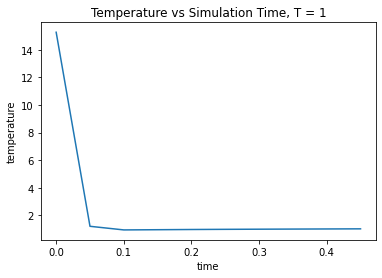

In [15]:
# T = 1

lx = 8
ly = 8
N = 12
dt = 0.0005
v0 = 1

Z = MDsystem(lx, ly, N, dt, BoundaryCondition.PBC)
Z.init(StartConf.Confined, v0)

time_array1 = np.zeros(10)
temp_array1 = np.zeros(10)

for i in range(10):
    temp_array1[i] = Z.auto_rescale(1,50)
    time_array1[i] = dt*i*100

print(temp_array1)   
    
pyplot.plot(time_array1, temp_array1);
pyplot.title('Temperature vs Simulation Time, T = 1')
pyplot.xlabel('time')
pyplot.ylabel('temperature');

[15.26354742  2.45534188  1.94757483  1.97506805  1.99714244  2.01342519
  2.02769481  2.04214395  2.05631593  2.05974331]


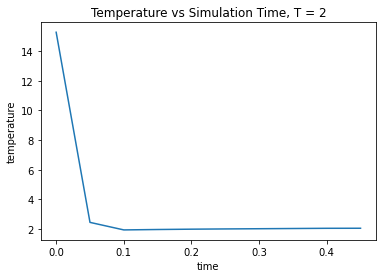

In [16]:
# T = 2

lx = 8
ly = 8
N = 12
dt = 0.0005
v0 = 1

Z = MDsystem(lx, ly, N, dt, BoundaryCondition.PBC)
Z.init(StartConf.Confined, v0)

time_array2 = np.zeros(10)
temp_array2 = np.zeros(10)

for i in range(10):
    temp_array2[i] = Z.auto_rescale(2,50)
    time_array2[i] = dt*i*100

print(temp_array2) 
    
pyplot.plot(time_array2, temp_array2);
pyplot.title('Temperature vs Simulation Time, T = 2')
pyplot.xlabel('time')
pyplot.ylabel('temperature');

[15.26354742  4.93914438  3.94385029  3.98897067  4.01954735  4.04476101
  4.06812864  4.05874864  3.79467765  3.42288864]


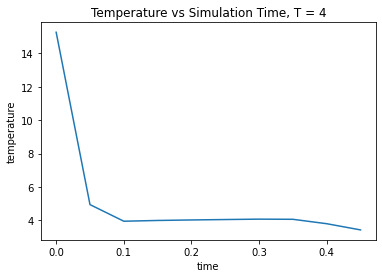

In [17]:
# T = 4

lx = 8
ly = 8
N = 12
dt = 0.0005
v0 = 1

Z = MDsystem(lx, ly, N, dt, BoundaryCondition.PBC)
Z.init(StartConf.Confined, v0)

time_array4 = np.zeros(10)
temp_array4 = np.zeros(10)

for i in range(10):
    temp_array4[i] = Z.auto_rescale(4,50)
    time_array4[i] = dt*i*100

print(temp_array4) 
    
pyplot.plot(time_array4, temp_array4);
pyplot.title('Temperature vs Simulation Time, T = 4')
pyplot.xlabel('time')
pyplot.ylabel('temperature');

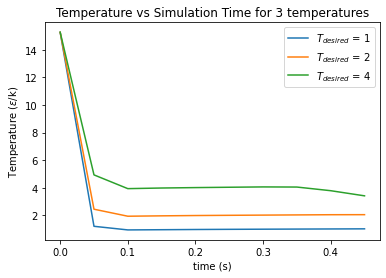

In [18]:
pyplot.plot(time_array1, temp_array1)
pyplot.plot(time_array2, temp_array2)
pyplot.plot(time_array4, temp_array4)

pyplot.title('Temperature vs Simulation Time for 3 temperatures')
pyplot.xlabel('time (s)')
pyplot.ylabel('Temperature ($\epsilon$/k)')
legend = ['$T_{desired}$ = 1', '$T_{desired}$ = 2', '$T_{desired}$ = 4']
pyplot.legend(legend);

Part 2: Plot the temperature averaged over intervals of 5 time steps as a function of time for each of the previous temperatures. What is the qualitative dependence of the temperature fluctuations?

Results should be three plots, one for each temperature. 

In [19]:
# First do T = 1. Need to start by preparing the system at this temperature.

# T = 1

lx = 8
ly = 8
N = 12
dt = 0.01  # At least at first will revert to .02
v0 = 1

Z = MDsystem(lx, ly, N, dt, BoundaryCondition.PBC)
Z.init(StartConf.Rectangular, v0)

time_array1 = np.zeros(10)
temp_array1 = np.zeros(10)

for i in range(10):
    temp_array1[i] = Z.auto_rescale(1,100)
    time_array1[i] = dt*i*100

print(temp_array1) 
    


[0.6872933  1.21341403 0.98348421 0.99336251 0.99830845 1.03810278
 1.02728119 0.96663463 1.06535849 0.98248169]


Looks like it's successfully been prepared at the desired temperature. Now I want to evolve it with Temp_evolve, not rescaling at each step.

In [20]:
# Now keep evolving it without rescaling. Average the temperature over five intervals. Plot average against center t. 

av_temp = np.zeros(100);
av_time = np.zeros(100);
av_temp[0] = Z.inst_temp()

for i in range(1,100):
    inst_temp = np.zeros(5)
    
    for j in range(5):
        Z.evolve()
        inst_temp[j] = Z.inst_temp()  
    
    av_temp[i] = np.sum(inst_temp)
    av_temp[i] /= 5
    
    av_time[i] = i*dt*5 - dt*5/2
        

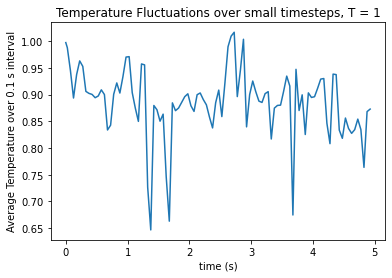

In [21]:
pyplot.plot(av_time, av_temp);
#av_time

pyplot.title('Temperature Fluctuations over small timesteps, T = 1')
pyplot.xlabel('time (s)')
pyplot.ylabel('Average Temperature over 0.1 s interval');

The temperature fluctuations look random. (However, some of them are very large!) Note that this was not the case before corrections - I don't think my system was reaching equilibrium. Now I'm going to do it using Temp_evolve instead of inst_temp. This will mean evolving the system 100 times and averaging to find the temperature. I will average five of these.

In [22]:
# T = 1

lx = 8
ly = 8
N = 12
dt = 0.01  # At least at first will revert to .02
v0 = 1

Z = MDsystem(lx, ly, N, dt, BoundaryCondition.PBC)
Z.init(StartConf.Rectangular, v0)

time_array1 = np.zeros(10)
temp_array1 = np.zeros(10)

for i in range(10):
    temp_array1[i] = Z.auto_rescale(1,100)
    time_array1[i] = dt*i*100

print(temp_array1) 

av_temp = np.zeros(100);
av_time = np.zeros(100);
av_temp[0] = Z.inst_temp()

for i in range(1,100):
    inst_temp = np.zeros(5)
    
    for j in range(5):
        Z.evolve()
        inst_temp[j] = Z.auto_rescale(1, 50)  
    
    av_temp[i] = np.sum(inst_temp)
    av_temp[i] /= 5
    
    av_time[i] = i*dt*5 - dt*5/2
    
    


[0.6872933  1.21341403 0.98348421 0.99336251 0.99830845 1.03810278
 1.02728119 0.96663463 1.06535849 0.98248169]


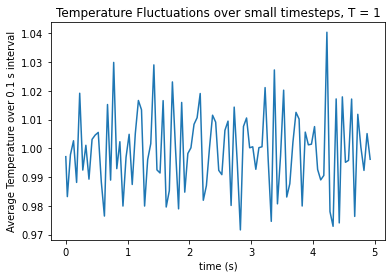

In [23]:
pyplot.plot(av_time, av_temp);
#av_time

pyplot.title('Temperature Fluctuations over small timesteps, T = 1')
pyplot.xlabel('time (s)')
pyplot.ylabel('Average Temperature over 0.1 s interval');

[0.6872933  2.36970068 2.02702726 2.07251799 1.95111143 2.02809238
 1.98035955 1.92176288 1.9424192  2.0147562 ]


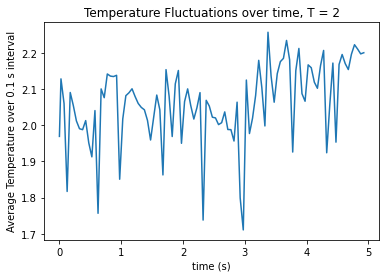

In [24]:
# T = 2

# for T = 2
lx = 8
ly = 8
N = 12
dt = 0.01
v0 = 1

Z = MDsystem(lx, ly, N, dt, BoundaryCondition.PBC)
Z.init(StartConf.Rectangular, v0)

time_array2 = np.zeros(10)
temp_array2 = np.zeros(10)

for i in range(10):
    temp_array2[i] = Z.auto_rescale(2,100)
    time_array2[i] = dt*i*100
    
print(temp_array2)
    
av_temp = np.zeros(100);
av_time = np.zeros(100);
av_temp[0] = Z.inst_temp()

for i in range(1,100):
    inst_temp = np.zeros(5)
    
    for j in range(5):
        Z.evolve()
        inst_temp[j] = Z.inst_temp()
    
    av_temp[i] = np.sum(inst_temp)
    av_temp[i] /= 5
    
    av_time[i] = i*dt*5 - dt*5/2
        
        
pyplot.plot(av_time, av_temp);
#av_time

pyplot.title('Temperature Fluctuations over time, T = 2')
pyplot.xlabel('time (s)')
pyplot.ylabel('Average Temperature over 0.1 s interval');


[0.6872933  4.68980583 4.10340237 3.89398246 3.98403748 4.06055001
 3.90279328 3.98351002 4.04453399 4.04929532]


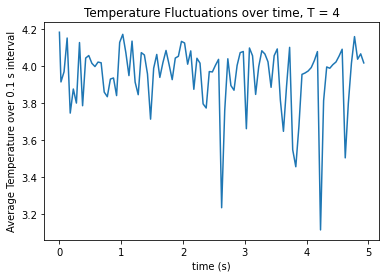

In [25]:
# T = 4

lx = 8
ly = 8
N = 12
dt = 0.01  # At least at first will revert to .02
v0 = 1

Z = MDsystem(lx, ly, N, dt, BoundaryCondition.PBC)
Z.init(StartConf.Rectangular, v0)

time_array1 = np.zeros(10)
temp_array1 = np.zeros(10)

for i in range(10):
    temp_array1[i] = Z.auto_rescale(4,100)
    time_array1[i] = dt*i*100
    
print(temp_array1)
    
av_temp = np.zeros(100);
av_time = np.zeros(100);
av_temp[0] = Z.inst_temp()

for i in range(1,100):
    inst_temp = np.zeros(5)
    
    for j in range(5):
        Z.evolve()
        inst_temp[j] = Z.inst_temp()
    
    av_temp[i] = np.sum(inst_temp)
    av_temp[i] /= 5
    
    av_time[i] = i*dt*5 - dt*5/2
        
        
pyplot.plot(av_time, av_temp);
#av_time

pyplot.title('Temperature Fluctuations over time, T = 4')
pyplot.xlabel('time (s)')
pyplot.ylabel('Average Temperature over 0.1 s interval');



Part 3: Calculate the kinetic and potential energies as a function of time. Are the kinetic and potential energies conserved separately? 

Do this for one case. If the total energy is not conserved, there's probably a problem with the potential energy calculation. 

First, check them separately.

In [26]:
# Kinetic energy

# Prepare the system at T = 4

lx = 8
ly = 8
N = 12
dt = 0.02  # At least at first will revert to .02
v0 = 1

Z = MDsystem(lx, ly, N, dt, BoundaryCondition.PBC)
Z.init(StartConf.Rectangular, v0)

time_array1 = np.zeros(10)
temp_array1 = np.zeros(10)

for i in range(10):
    temp_array1[i] = Z.auto_rescale(4,100)
    time_array1[i] = dt*i*100
   

In [27]:
# Now write a loop that calculates the kinetic energy as the system evolves.

kinetic_array = np.zeros(50)
time_array = np.zeros(50)

for i in range(50):
    kinetic_array[i] = Z.kinetic_energy()
    time_array[i] = i*dt
    Z.evolve()

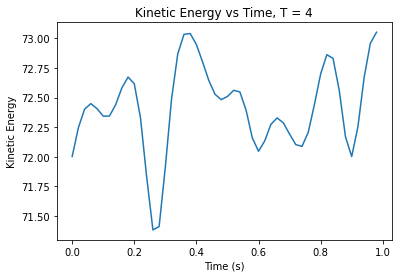

In [28]:
pyplot.plot(time_array, kinetic_array)
pyplot.title('Kinetic Energy vs Time, T = 4')
pyplot.xlabel('Time (s)')
pyplot.ylabel('Kinetic Energy');

It's not really conserved by itself, but should check potential to see what's going on. I'm still skeptical that equilibrium is actually being reached. 

Now check potential energy.

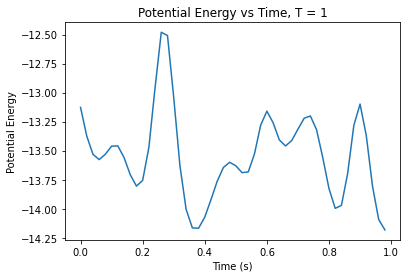

In [29]:
# Potential energy

# Prepare the system at T = 1

lx = 8
ly = 8
N = 12
dt = 0.02  # At least at first will revert to .02
v0 = 1

Z = MDsystem(lx, ly, N, dt, BoundaryCondition.PBC)
Z.init(StartConf.Rectangular, v0)

time_array1 = np.zeros(10)
temp_array1 = np.zeros(10)

for i in range(10):
    temp_array1[i] = Z.auto_rescale(4,100)
    time_array1[i] = dt*i*100
    
#print(temp_array1)
    
pot_array = np.zeros(50)
time_array = np.zeros(50)

for i in range(50):
    pot_array[i] = Z.pot_energy()
    time_array[i] = i*dt
    Z.evolve()  
    

pyplot.plot(time_array, pot_array)
pyplot.title('Potential Energy vs Time, T = 1')
pyplot.xlabel('Time (s)')
pyplot.ylabel('Potential Energy');


At a glance, this isn't bad. Notice it's  negative (attractive). There's an odd positive spike, where particles must be close together. Have to check the total energy to see if this makes sense.

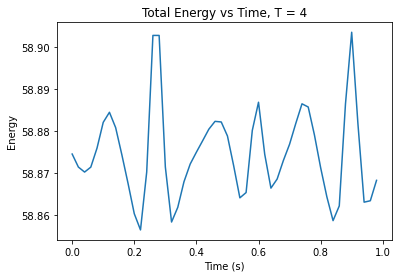

In [30]:
# Total energy

# Prepare the system at T = 1

lx = 8
ly = 8
N = 12
dt = 0.02  # At least at first will revert to .02
v0 = 1

Z = MDsystem(lx, ly, N, dt, BoundaryCondition.PBC)
Z.init(StartConf.Rectangular, v0)

time_array1 = np.zeros(10)
temp_array1 = np.zeros(10)

for i in range(10):
    temp_array1[i] = Z.auto_rescale(4,100)
    time_array1[i] = dt*i*100
    
#print(temp_array1)
    
tot_array = np.zeros(50)
time_array = np.zeros(50)

for i in range(50):
    tot_array[i] = Z.total_energy()
    time_array[i] = i*dt
    Z.evolve()  
    

pyplot.plot(time_array, tot_array)
pyplot.title('Total Energy vs Time, T = 4')
pyplot.xlabel('Time (s)')
pyplot.ylabel('Energy');

This looks mostly conserved! There is some small fluctuation around an average value.

# After some emails with you, it sounds like I misunderstood, and should rescale while finding the temperature over five intervals, even after the system is prepared in equilibrium. I will do both this and the energy portion over again below. 

## Part 2 with continuous rescaling

[1.07088715e+14 3.42660458e+00 9.94543259e-01 1.03413826e+00
 1.00589156e+00 1.04445558e+00 9.81541396e-01 1.01533108e+00
 1.00371332e+00 9.66226272e-01]


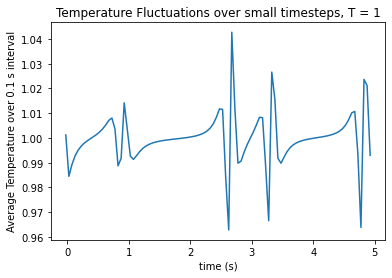

In [46]:
# T = 1

lx = 8
ly = 8
N = 12
dt = 0.01  
v0 = 1

Z = MDsystem(lx, ly, N, dt, BoundaryCondition.PBC)
Z.init(StartConf.Confined, v0)

time_array1 = np.zeros(10)
temp_array1 = np.zeros(10)

for i in range(10):
    temp_array1[i] = Z.auto_rescale(1,100)
    time_array1[i] = dt*i*100

print(temp_array1) 

av_temp = np.zeros(100);
av_time = np.zeros(100);
#av_temp[0] = Z.inst_temp()

for i in range(100):
    av_temp[i] = Z.auto_rescale(1, 5)   # This time each temp is calculated, then the system is evolved 5 times and rescaled
    
    av_time[i] = i*dt*5 - dt*5/2
    
pyplot.plot(av_time, av_temp);
#av_time

pyplot.title('Temperature Fluctuations over small timesteps, T = 1')
pyplot.xlabel('time (s)')
pyplot.ylabel('Average Temperature over 0.1 s interval');

[1.07088715e+14 6.64566765e+00 1.99353713e+00 2.03590619e+00
 2.00571002e+00 2.03579179e+00 1.97915587e+00 1.97601908e+00
 2.01658040e+00 2.03739733e+00]


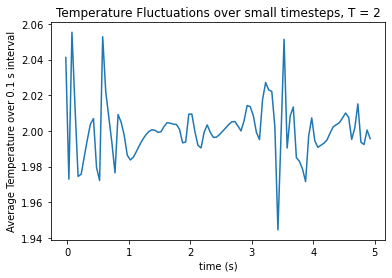

In [47]:
# T = 2

lx = 8
ly = 8
N = 12
dt = 0.01  
v0 = 1

Z = MDsystem(lx, ly, N, dt, BoundaryCondition.PBC)
Z.init(StartConf.Confined, v0)

time_array1 = np.zeros(10)
temp_array1 = np.zeros(10)

for i in range(10):
    temp_array1[i] = Z.auto_rescale(2,100)
    time_array1[i] = dt*i*100

print(temp_array1) 

av_temp = np.zeros(100);
av_time = np.zeros(100);
#av_temp[0] = Z.inst_temp()

for i in range(100):
    av_temp[i] = Z.auto_rescale(2, 5)   # This time each temp is calculated, then the system is evolved 5 times and rescaled
    
    av_time[i] = i*dt*5 - dt*5/2
    
pyplot.plot(av_time, av_temp);
#av_time

pyplot.title('Temperature Fluctuations over small timesteps, T = 2')
pyplot.xlabel('time (s)')
pyplot.ylabel('Average Temperature over 0.1 s interval');

[1.07088715e+14 1.30837938e+01 3.99308015e+00 4.03670218e+00
 4.00495962e+00 4.04603689e+00 3.95961062e+00 3.97744262e+00
 4.00082161e+00 4.01876734e+00]


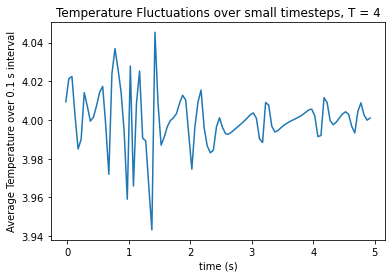

In [48]:
# T = 4

lx = 8
ly = 8
N = 12
dt = 0.01  
v0 = 1

Z = MDsystem(lx, ly, N, dt, BoundaryCondition.PBC)
Z.init(StartConf.Confined, v0)

time_array1 = np.zeros(10)
temp_array1 = np.zeros(10)

for i in range(10):
    temp_array1[i] = Z.auto_rescale(4,100)
    time_array1[i] = dt*i*100

print(temp_array1) 

av_temp = np.zeros(100);
av_time = np.zeros(100);
#av_temp[0] = Z.inst_temp()

for i in range(100):
    av_temp[i] = Z.auto_rescale(4, 5)   # This time each temp is calculated, then the system is evolved 5 times and rescaled
    
    av_time[i] = i*dt*5 - dt*5/2
    
pyplot.plot(av_time, av_temp);
#av_time

pyplot.title('Temperature Fluctuations over small timesteps, T = 4')
pyplot.xlabel('time (s)')
pyplot.ylabel('Average Temperature over 0.1 s interval');

The fluctuations look random. Indeed, the rescaling has made this behavior look more realistic. 

## Now make the same change to the calculation of energy

[1.07088715e+14 3.42660458e+00 9.94543259e-01 1.03413826e+00
 1.00589156e+00 1.04445558e+00 9.81541396e-01 1.01533108e+00
 1.00371332e+00 9.66226272e-01]


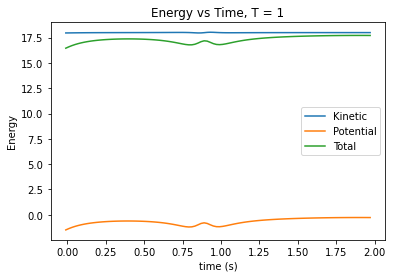

In [72]:
T = 1

lx = 8
ly = 8
N = 12
dt = 0.01  
v0 = 1

Z = MDsystem(lx, ly, N, dt, BoundaryCondition.PBC)
Z.init(StartConf.Confined, v0)

time_array1 = np.zeros(10)
temp_array1 = np.zeros(10)

for i in range(10):
    temp_array1[i] = Z.auto_rescale(T,100)
    time_array1[i] = dt*i*100

print(temp_array1) 

av_temp = np.zeros(100);
av_time = np.zeros(100);
#av_temp[0] = Z.inst_temp()

kin = np.zeros(100)
pot = np.zeros(100)
tot = np.zeros(100)

n = 2

for i in range(100):
    av_temp[i] = Z.auto_rescale(T, n)   # This time each temp is calculated, then the system is evolved n times and rescaled
    
    av_time[i] = i*dt*n - dt*n/2
    
    kin[i] = Z.kinetic_energy()
    pot[i] = Z.pot_energy()
    tot[i] = Z.total_energy()
    
pyplot.plot(av_time, kin);
#av_time
pyplot.plot(av_time, pot)
pyplot.plot(av_time, tot)

pyplot.title('Energy vs Time, T = 1')
pyplot.xlabel('time (s)')
pyplot.ylabel('Energy');

pyplot.legend(['Kinetic','Potential','Total']);

Definitely odd to me that the total energy is changing at all. Maybe a relic of beginning in a confined configuration? I would have thought that would be washed out in the rescaling - system should forget where it started, but maybe this is not happening and the initial configuration is too special.

[1.07088715e+14 6.64566765e+00 1.99353713e+00 2.03590619e+00
 2.00571002e+00 2.03579179e+00 1.97915587e+00 1.97601908e+00
 2.01658040e+00 2.03739733e+00]


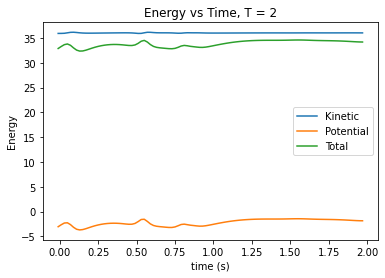

In [74]:
T = 2

lx = 8
ly = 8
N = 12
dt = 0.01  
v0 = 1

Z = MDsystem(lx, ly, N, dt, BoundaryCondition.PBC)
Z.init(StartConf.Confined, v0)

time_array1 = np.zeros(10)
temp_array1 = np.zeros(10)

for i in range(10):
    temp_array1[i] = Z.auto_rescale(T,100)
    time_array1[i] = dt*i*100

print(temp_array1) 

av_temp = np.zeros(100);
av_time = np.zeros(100);
#av_temp[0] = Z.inst_temp()

kin = np.zeros(100)
pot = np.zeros(100)
tot = np.zeros(100)

n = 2

for i in range(100):
    av_temp[i] = Z.auto_rescale(T, n)   # This time each temp is calculated, then the system is evolved n times and rescaled
    
    av_time[i] = i*dt*n - dt*n/2
    
    kin[i] = Z.kinetic_energy()
    pot[i] = Z.pot_energy()
    tot[i] = Z.total_energy()
    
pyplot.plot(av_time, kin);
#av_time
pyplot.plot(av_time, pot)
pyplot.plot(av_time, tot)

pyplot.title('Energy vs Time, T = 2')
pyplot.xlabel('time (s)')
pyplot.ylabel('Energy');

pyplot.legend(['Kinetic','Potential','Total']);

[1.07088715e+14 1.30837938e+01 3.99308015e+00 4.03670218e+00
 4.00495962e+00 4.04603689e+00 3.95961062e+00 3.97744262e+00
 4.00082161e+00 4.01876734e+00]


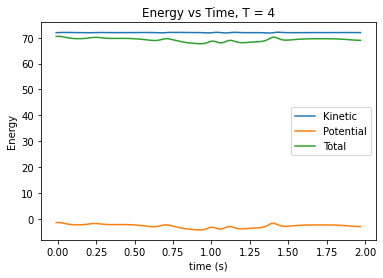

In [75]:
T = 4

lx = 8
ly = 8
N = 12
dt = 0.01  
v0 = 1

Z = MDsystem(lx, ly, N, dt, BoundaryCondition.PBC)
Z.init(StartConf.Confined, v0)

time_array1 = np.zeros(10)
temp_array1 = np.zeros(10)

for i in range(10):
    temp_array1[i] = Z.auto_rescale(T,100)
    time_array1[i] = dt*i*100

print(temp_array1) 

av_temp = np.zeros(100);
av_time = np.zeros(100);
#av_temp[0] = Z.inst_temp()

kin = np.zeros(100)
pot = np.zeros(100)
tot = np.zeros(100)

n = 2

for i in range(100):
    av_temp[i] = Z.auto_rescale(T, n)   # This time each temp is calculated, then the system is evolved n times and rescaled
    
    av_time[i] = i*dt*n - dt*n/2
    
    kin[i] = Z.kinetic_energy()
    pot[i] = Z.pot_energy()
    tot[i] = Z.total_energy()
    
pyplot.plot(av_time, kin);
#av_time
pyplot.plot(av_time, pot)
pyplot.plot(av_time, tot)

pyplot.title('Energy vs Time, T = 4')
pyplot.xlabel('time (s)')
pyplot.ylabel('Energy');

pyplot.legend(['Kinetic','Potential','Total']);

It looks a bit better as the temperature becomes higher. Out of curiosity do one more at T = 10.

[1.07088715e+14 3.23981722e+01 9.99282020e+00 1.00371513e+01
 1.00044524e+01 1.00507847e+01 9.95825962e+00 9.97995733e+00
 1.00030718e+01 1.00529946e+01]


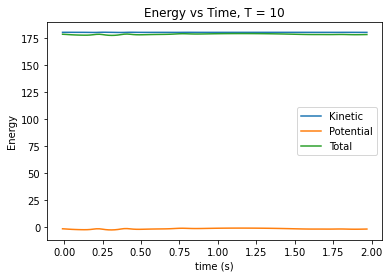

In [76]:
T = 10

lx = 8
ly = 8
N = 12
dt = 0.01  
v0 = 1

Z = MDsystem(lx, ly, N, dt, BoundaryCondition.PBC)
Z.init(StartConf.Confined, v0)

time_array1 = np.zeros(10)
temp_array1 = np.zeros(10)

for i in range(10):
    temp_array1[i] = Z.auto_rescale(T,100)
    time_array1[i] = dt*i*100

print(temp_array1) 

av_temp = np.zeros(100);
av_time = np.zeros(100);
#av_temp[0] = Z.inst_temp()

kin = np.zeros(100)
pot = np.zeros(100)
tot = np.zeros(100)

n = 2

for i in range(100):
    av_temp[i] = Z.auto_rescale(T, n)   # This time each temp is calculated, then the system is evolved n times and rescaled
    
    av_time[i] = i*dt*n - dt*n/2
    
    kin[i] = Z.kinetic_energy()
    pot[i] = Z.pot_energy()
    tot[i] = Z.total_energy()
    
pyplot.plot(av_time, kin);
#av_time
pyplot.plot(av_time, pot)
pyplot.plot(av_time, tot)

pyplot.title('Energy vs Time, T = 10')
pyplot.xlabel('time (s)')
pyplot.ylabel('Energy');

pyplot.legend(['Kinetic','Potential','Total']);